In [2]:
import re
import numpy as np
from scipy.optimize import linprog
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# NHẬP DỮ LIỆU VÀ ĐƯA BÀI TOÁN VỀ DẠNG CHUẨN

Trong quá trình xử lý, nếu bài toán đầu vào là một bài toán **tối đa hóa** **maximize**, chương trình sẽ tự động chuyển đổi về dạng chuẩn là **tối thiểu hóa minimize**. Quy tắc chuyển đổi được áp dụng như sau:

$$
\max f(x) = -\min [-f(x)]
$$

Chẳng hạn, nếu hàm mục tiêu là $ f(x) = 2x_1 + 3x_2 $, thì chương trình sẽ chuyển về hàm mục tiêu tương đương để giải dưới dạng tối thiểu hóa:

$$
-f(x) = -2x_1 - 3x_2,
$$

và do đó, vector hệ số mục tiêu được sử dụng trong chương trình sẽ là $ (-2,\ -3) $. Khi bài toán tìm **min** trả về giá trị là $-10$, thì giá trị tương ứng của bài toán gốc **maximize** sẽ là $10$.

Ngoài ra, các ràng buộc đầu vào cũng sẽ được chuẩn hóa về dạng bất phương trình kiểu $\leq$. Cụ thể, nếu ràng buộc ban đầu là:

$$
x_1 + x_2 \ge 3,
$$

thì chương trình sẽ tự động chuyển thành:

$$
- x_1 - x_2 \le -3.
$$

Đối với các ràng buộc đẳng thức $=$ hoặc những trường hợp phức tạp hơn, chẳng hạn như biến tự do không bị chặn hai phía, chương trình sẽ sử dụng thư viện **SciPy** để xử lý bài toán. Trong các trường hợp còn lại, mô hình bài toán sẽ được đưa về dạng chuẩn như sau:

$$
\begin{aligned}
&\min/\max && c^{\top}x = c_1x_1 + c_2x_2 + \cdots + c_nx_n \\
&\text{subject to} && Ax \leq b \quad \text{(or } Ax \geq b \text{)} \\
& && x \geq 0
\end{aligned}
$$

Trong đó,$A \in \mathbb{R}^{m \times n}$, $c^{\top}, x \in \mathbb{R}^n$, $b \in \mathbb{R}^m$.

**Lưu ý quan trọng:** Để đảm bảo chương trình hoạt động hiệu quả, **không nhập trực tiếp các bất phương trình có vế phải âm**, ví dụ:

$$
x_1 + x_2 \le -5.
$$

Thay vào đó, nên chuyển về dạng tương đương:

$$
- x_1 - x_2 \ge 5,
$$

sau đó nhập vào chương trình. Chương trình sẽ tự động xử lý và chuyển về dạng chuẩn hóa phù hợp.


In [28]:
# Constants
EPSILON = 1e-9
def get_problem_from_keyboard():
    """Gets the LP problem definition from keyboard input."""
    print("\n--- Enter Your Linear Programming Problem ---")
    print("Example format:")
    print("maximize z = 8x1 + 1x2")
    print("x1 + x2 <= 40")
    print("2x1 + x2 <= 60")
    print("(Type 'done' on a new line when finished)")
    print("---------------------------------------------")

    lines = []
    print("Enter objective function: ")
    while True: # Loop for objective function until a non-empty line is given
        line = input("> ").strip()
        if line:
            lines.append(line)
            break
        else:
            print("Objective function cannot be empty. Please enter it.")

    print("Enter constraints (one per line, type 'done' to finish):")
    while True:
        line = input("> ").strip()
        if line.lower() == 'done':
            break
        if line: # Only add non-empty lines
            lines.append(line)

    if len(lines) < 2: # At least one objective and one constraint (or just objective if unconstrained)
        print("No constraints entered. Please define at least the objective.") # Adjusted message
        # Allow proceeding if only objective is given, though simplex typically needs constraints.
        # The parser/solver will handle it if it's an unconstrained problem.
        if not lines: # No input at all
             print("No input data. Exiting program.")
             return None

    return lines

def parse_objective(line):
    m = re.match(r"^(maximize|minimize)\s+z\s*=\s*(.+)$", line, re.IGNORECASE)
    if not m:
        raise ValueError("Objective function format invalid. Use 'maximize z = ...' or 'minimize z = ...'.")
    sense = m.group(1).lower()
    expr = m.group(2)
    terms = re.findall(r"([+-]?\s*\d*\.?\d*)\s*\*?x(\d+)", expr)

    coeffs = {}
    for raw_coeff, idx in terms:
        idx = int(idx) - 1
        coef = raw_coeff.replace(' ', '')
        if coef in ['', '+']:
            coef = 1.0
        elif coef == '-':
            coef = -1.0
        else:
            coef = float(coef)
        coeffs[idx] = coef

    n = max(coeffs.keys()) + 1
    c = np.zeros(n)
    for idx, coef in coeffs.items():
        c[idx] = coef

    if sense == 'maximize':
        c = -c
    return c

def parse_constraints(lines, n_vars):
    A_ub, b_ub, A_eq, b_eq = [], [], [], []

    for line in lines:
        if line.lower().startswith(('maximize', 'minimize')):
            continue

        m = re.match(r"^(.+?)\s*(<=|>=|=)\s*(.+)$", line)
        if not m:
            raise ValueError(f"Invalid constraint format: {line}")
        lhs, op, rhs = m.group(1), m.group(2), m.group(3)
        b_val = float(rhs)
        row = np.zeros(n_vars)

        for term in re.findall(r"([+-]?\s*\d*\.?\d*)\s*\*?x(\d+)", lhs):
            raw, idx = term
            idx = int(idx) - 1
            coef = raw.replace(' ', '')
            if coef in ['', '+']:
                coef = 1.0
            elif coef == '-':
                coef = -1.0
            else:
                coef = float(coef)
            row[idx] = coef

        if op == '<=':
            A_ub.append(row)
            b_ub.append(b_val)
        elif op == '>=':
            A_ub.append(-row)
            b_ub.append(-b_val)
        else:
            A_eq.append(row)
            b_eq.append(b_val)

    A_ub = np.array(A_ub) if A_ub else None
    b_ub = np.array(b_ub) if b_ub else None
    A_eq = np.array(A_eq) if A_eq else None
    b_eq = np.array(b_eq) if b_eq else None
    return A_ub, b_ub, A_eq, b_eq


Chạy đoạn code sau để nhập bài toán, lưu ý định dạng: maximize, minimize, x1, x2, x3,...

In [29]:
lines = get_problem_from_keyboard()


--- Enter Your Linear Programming Problem ---
Example format:
maximize z = 8x1 + 1x2
x1 + x2 <= 40
2x1 + x2 <= 60
(Type 'done' on a new line when finished)
---------------------------------------------
Enter objective function: 
> maximize z = x1 - 2x2
Enter constraints (one per line, type 'done' to finish):
> x1 + 3x2 <= 4
> x1 - 4x2 <= 2
> done


Chạy đoạn code sau để trích xuất các thông tin cần thiết cho bài toán

In [30]:
print("These following parameters will be used for The Standard Form in Scipy or any program")
print("If the problem is maximizing, we will convert it to minimizing by defining c=-c, then we change the sign of the optimal value")
c = parse_objective(lines[0])
print("c = ", c)
n_vars = len(c)
A_ub, b_ub, A_eq, b_eq = parse_constraints(lines, n_vars)
bounds = [(0, None)] * n_vars
print("A_ub = ", A_ub)
print("b_ub = ",b_ub)
print("A_eq = ",A_eq)
print("b_ed = ",b_eq)

These following parameters will be used for The Standard Form in Scipy or any program
If the problem is maximizing, we will convert it to minimizing by defining c=-c, then we change the sign of the optimal value
c =  [-1.  2.]
A_ub =  [[ 1.  3.]
 [ 1. -4.]]
b_ub =  [4. 2.]
A_eq =  None
b_ed =  None


# SỬ DỤNG SCIPY ĐỂ GIẢI BÀI TOÁN TỔNG QUÁT

Trước khi áp dụng các phương pháp giải thuật khác, chúng ta sẽ tiến hành kiểm tra bài toán bằng thư viện **SciPy**. Qua bước kiểm tra này, có thể xác định được tính khả thi của bài toán, đồng thời đánh giá được bài toán có bị giới hạn nội tại hay không, cũng như xác định giá trị tối ưu (nếu tồn tại).

Quá trình kiểm tra này được xem là bước cơ bản và quan trọng nhằm đảm bảo tính chính xác và hiệu quả cho các phương pháp giải thuật tiếp theo. Do đó, mục đích của việc sử dụng **SciPy** trong giai đoạn đầu là để đánh giá và xác minh tính khả thi của bài toán trước khi triển khai các kỹ thuật xử lý phức tạp hơn.

In [27]:
n_vars = len(c)
bounds = [(0, None)] * n_vars
res = linprog(
    c=c,
    A_ub=A_ub,
    b_ub=b_ub,
    A_eq=A_eq,
    b_eq=b_eq,
    bounds=bounds,
    method='highs',  # Modern and recommended solver
)

# === OUTPUT FULL INFORMATION ===
print("Optimization result from scipy.optimize.linprog:")
print(f"Status: {res.message}")
print(f"Success: {res.success}")
print(f"Status Code: {res.status} (0 means success)")

if res.success:
    if lines[0].lower().startswith('maximize'):
        print(f"Optimal Value of Objective Function: {-res.fun}")
    else:
        print(f"Optimal Value of Objective Function: {res.fun}")
    print(f"Optimal Solution x: {res.x}")
    print(f"Number of Iterations: {res.nit}")
    # Slack and Residuals are usually available even if not optimal, but checking success is safer for duals
    if res.slack is not None:
        print(f"Slack Variables (A_ub @ x - b_ub): {res.slack}")
    if res.eqlin.residual is not None: # Use .residual attribute for eqlin
        print(f"Residuals (A_eq @ x - b_eq): {res.eqlin.residual}")
    # Dual prices are typically only available and meaningful for an optimal solution
    if hasattr(res, 'dual') and res.dual is not None:
        print(f"Marginals (dual prices): {res.dual}")
    else:
        print("Marginals (dual prices) not available for this solution status.")
else:
    print("Optimization did not converge to an optimal solution.")
    # You can add more specific messages based on res.status if needed
    # e.g., if res.status == 2: print("Problem is infeasible.")
    # e.g., if res.status == 3: print("Problem is unbounded.")


Optimization result from scipy.optimize.linprog:
Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Success: True
Status Code: 0 (0 means success)
Optimal Value of Objective Function: 0.6000000000000005
Optimal Solution x: [0.  2.8 3.4]
Number of Iterations: 3
Slack Variables (A_ub @ x - b_ub): [0. 0. 3.]
Residuals (A_eq @ x - b_eq): []
Marginals (dual prices) not available for this solution status.


# PHƯƠNG PHÁP HÌNH HỌC


Phương pháp này chỉ sử dụng cho hàm hai biến $f(x_1,x_2)$. Nếu bài toán không có tập khả thi hoặc không khả thi, chương trình sẽ thông báo lỗi và đưa ra cảnh báo phù hợp. Điểm tối ưu của bài toán sẽ được biểu diễn trực quan trên đồ thị, giúp người dùng dễ dàng nhận biết vị trí và giá trị tối ưu.

$$
\begin{aligned}
\text{maximize} \quad z = x_1 + x_2\\
\text{subject to}\quad
2x_1 + 3x_2 &\le 5 \\
-2x_1 + x_2 &\le 1 \\
3x_1 - x_2 &\le 4 \\
x_1,x_2 &\ge 0.
\end{aligned}
$$

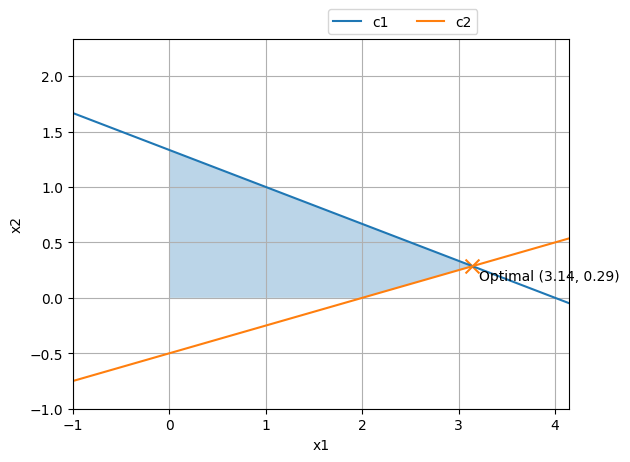

In [42]:
def plot_lp_geometric_with_legend(A_ub, b_ub, c, bounds, constraint_names=None):
    # Build full constraint set including bounds
    A = list(A_ub)
    b = list(b_ub)
    # names for original constraints
    names = list(constraint_names) if constraint_names is not None else [f"c{i+1}" for i in range(len(A_ub))]
    # Extend for bounds (not shown in legend by default)
    for i, (low, high) in enumerate(bounds):
        if low is not None:
            A.append(np.array([-1 if j == i else 0 for j in range(2)]))
            b.append(-low)
        if high is not None:
            A.append(np.array([1 if j == i else 0 for j in range(2)]))
            b.append(high)
    A = np.array(A)
    b = np.array(b)

    # Find vertices
    points = []
    m = len(b)
    for i in range(m):
        for j in range(i+1, m):
            sub = np.vstack((A[i], A[j]))
            if np.linalg.matrix_rank(sub) == 2:
                pt = np.linalg.solve(sub, [b[i], b[j]])
                if np.all(A @ pt <= b + 1e-6):
                    points.append(pt)
    points = np.array(points)
    if len(points) < 3:
        raise ValueError("Feasible region is unbounded or empty.")
    hull = ConvexHull(points)
    hull_pts = points[hull.vertices]

    # Solve LP
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    if not res.success:
        raise ValueError("LP solver failed: " + res.message)

    # Plot
    plt.figure()
    x_min, x_max = hull_pts[:,0].min() - 1, hull_pts[:,0].max() + 1
    x_vals = np.linspace(x_min, x_max, 200)

    # Plot constraints with labels for legend
    for idx, (a, b_val) in enumerate(zip(A_ub, b_ub)):
        if abs(a[1]) > 1e-6:
            y_vals = (b_val - a[0]*x_vals) / a[1]
            plt.plot(x_vals, y_vals, label=names[idx])

    # Shade feasible region
    plt.fill(hull_pts[:,0], hull_pts[:,1], alpha=0.3)

    # Plot and annotate optimal point
    x_opt, y_opt = res.x
    plt.scatter(x_opt, y_opt, marker='x', s=100)
    plt.annotate(f"Optimal ({x_opt:.2f}, {y_opt:.2f})",
                 xy=(x_opt, y_opt), xytext=(5, -10),
                 textcoords='offset points')

    # Legend at top
    plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1.10), ncol=len(A_ub))

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    plt.xlim(x_min, x_max)
    plt.ylim(hull_pts[:,1].min() - 1, hull_pts[:,1].max() + 1)
    plt.show()

def main():
    if lines[0].lower().startswith('maximize'):
        plot_lp_geometric_with_legend(A_ub, b_ub, -c, bounds, constraint_names=None)
    else:
        plot_lp_geometric_with_legend(A_ub, b_ub, c, bounds, constraint_names=None)
if __name__ == '__main__':
    main()

# PHƯƠNG PHÁP ĐƠN HÌNH

Với các bài toán có nhiều hơn ba biến mục tiêu, tức là hàm mục tiêu dạng $ f(x_1, x_2, x_3, \ldots) $, chúng ta sẽ sử dụng **thuật toán đơn hình**. Tuy nhiên, trong một số trường hợp, thuật toán đơn hình tiêu chuẩn có thể không hoạt động hiệu quả, chẳng hạn như khi không thể xác định được **từ điển xuất phát khả thi**.

Trong những tình huống đó, phương pháp **đơn hình hai pha** hoặc **phương pháp đơn hình đối ngẫu** sẽ được áp dụng nhằm đảm bảo bài toán được giải quyết đúng và tối ưu.

Dưới đây là ví dụ minh họa cho trường hợp này:

\begin{aligned}
\text{maximize} \quad & z = x_1 + 2x_2 - x_3 \\
\text{subject to} \quad &
\begin{cases}
2x_1 + x_2 + x_3 \leq 14, \\
4x_1 + 2x_2 + 3x_3 \leq 28, \\
2x_1 + 5x_2 + 5x_3 \leq 30, \\
x_1, x_2, x_3 \geq 0.
\end{cases}
\end{aligned}


In [14]:
import copy

class SimplexDictionary:
    def __init__(self, basic_vars, nonbasic_vars, rows, objective):
        self.basic = basic_vars[:]
        self.nonbasic = nonbasic_vars[:]
        self.rows = {bv: rows[bv].copy() for bv in basic_vars}
        self.obj = objective.copy()

    def __str__(self):
        lines = []
        for bv in self.basic:
            coeffs = self.rows[bv]
            terms = []
            for var, coef in coeffs.items():
                if var == 'const':
                    continue
                terms.append(f"{coef:+g}*{var}")
            expr = "".join(terms) if terms else ""
            lines.append(f"{bv} = {coeffs['const']}{expr}")
        # z-row
        terms = []
        for var, coef in self.obj.items():
            if var == 'const':
                continue
            terms.append(f"{coef:+g}*{var}")
        z_expr = "".join(terms)
        lines.append(f"z = {self.obj['const']}{z_expr}")
        return "\n".join(lines)

    def pivot(self, enter, leave):
        if leave is None:
            raise ValueError("Cannot pivot without a leaving variable.")
        new_rows = {}
        pivot_row = self.rows[leave]
        factor = pivot_row[enter]
        if abs(factor) < 1e-12:
            raise ZeroDivisionError(f"Pivot coefficient is zero for var {enter} in row {leave}")
        # Solve pivot row for entering var
        new_pivot = {}
        new_pivot['const'] = -pivot_row['const'] / factor
        for var, coef in pivot_row.items():
            if var in ('const', enter):
                continue
            new_pivot[var] = -coef / factor
        new_rows[enter] = new_pivot
        # Update other rows
        for bv in self.basic:
            if bv == leave:
                continue
            row = self.rows[bv]
            coef = row.get(enter, 0)
            updated = {}
            for var in set(row) | set(new_pivot):
                if var == enter:
                    continue
                updated[var] = row.get(var, 0) + coef * new_pivot.get(var, 0)
            updated['const'] = row['const'] + coef * new_pivot['const']
            new_rows[bv] = updated
        # Update objective
        coef_z = self.obj.get(enter, 0)
        new_obj = {}
        new_obj['const'] = self.obj['const'] + coef_z * new_pivot['const']
        for var in set(self.obj) | set(new_pivot):
            if var == 'const' or var == enter:
                continue
            new_obj[var] = self.obj.get(var, 0) + coef_z * new_pivot.get(var, 0)
        new_rows_obj = new_obj
        # Swap basic and nonbasic
        self.basic = [enter if v == leave else v for v in self.basic]
        self.nonbasic = [leave if v == enter else v for v in self.nonbasic]
        self.rows = {bv: new_rows[bv] for bv in self.basic}
        self.obj = new_rows_obj

    def find_entering(self):
        for var, coef in sorted(self.obj.items(), key=lambda x: -x[1]):
            if var != 'const' and coef > 0:
                return var
        return None

    def find_leaving(self, enter):
        ratios = []
        for bv in self.basic:
            coeff = self.rows[bv].get(enter, 0)
            if coeff < 0:
                ratio = self.rows[bv]['const'] / (-coeff)
                ratios.append((ratio, bv))
        if not ratios:
            return None
        return min(ratios)[1]

    def is_optimal(self):
        return all(coef <= 0 for var, coef in self.obj.items() if var != 'const')


def simplex(c, A, b):
    m = len(b)
    n = len(c)
    basic = [f's{i+1}' for i in range(m)]
    nonbasic = [f'x{j+1}' for j in range(n)]
    rows = {}
    for i in range(m):
        expr = {'const': b[i]}
        for j in range(n):
            expr[f'x{j+1}'] = -A[i][j]
        rows[f's{i+1}'] = expr
    objective = {'const': 0}
    for j in range(n):
        objective[f'x{j+1}'] = c[j]
    D = SimplexDictionary(basic, nonbasic, rows, objective)

    print("Initial Dictionary:")
    print(D)
    print()

    step = 1
    while not D.is_optimal():
        enter = D.find_entering()
        if enter is None:
            print("Optimal reached or no positive coefficients.")
            break
        leave = D.find_leaving(enter)
        if leave is None:
            print(f"Unbounded: no leaving variable for {enter}.")
            break
        print(f"Pivot {step}: Enter {enter}, Leave {leave}")
        D.pivot(enter, leave)
        print(D)
        print()
        step += 1

    sol = {var: 0 for var in D.nonbasic}
    sol.update({bv: D.rows[bv]['const'] for bv in D.basic})
    print("Solution:")
    for var in sorted(sol):
        print(f"{var} = {sol[var]}")
    print(f"z = {D.obj['const']}")
    return sol, D.obj['const']


def main():
    if lines[0].lower().startswith('maximize'):
        simplex(-c, A_ub, b_ub)
    else:
        simplex(c,A_ub,b_ub)

if __name__ == '__main__':
    main()


Initial Dictionary:
s1 = 14.0-2*x1-1*x2-1*x3
s2 = 28.0-4*x1-2*x2-3*x3
s3 = 30.0-2*x1-5*x2-5*x3
z = 0+1*x1+2*x2+1*x3

Pivot 1: Enter x2, Leave s3
s1 = 8.0-1.6*x1+0*x3
s2 = 16.0-3.2*x1-1*x3
x2 = 6.0-0.4*x1-1*x3
z = 12.0+0.2*x1-1*x3

Pivot 2: Enter x1, Leave s1
x1 = 5.0+0*x3
s2 = 0.0-1*x3
x2 = 4.0-1*x3
z = 13.0-1*x3

Solution:
s1 = 0
s2 = 0.0
s3 = 0
x1 = 5.0
x2 = 4.0
x3 = 0
z = 13.0


# PHƯƠNG PHÁP ĐƠN HÌNH HAI PHA

Có một số bài toán tuyến tính mà **phương pháp đơn hình thông thường không thể áp dụng hiệu quả**, bao gồm các trường hợp sau:

1. Bài toán có ràng buộc dạng đẳng thức ($=$) hoặc bất phương trình kiểu lớn hơn hoặc bằng ($\geq$), thay vì chỉ là bất phương trình nhỏ hơn hoặc bằng ($\leq$).

2. Hệ ràng buộc không cung cấp nghiệm cơ bản khả thi ban đầu rõ ràng, khiến việc khởi tạo thuật toán đơn hình truyền thống gặp khó khăn.

3. Không thể bắt đầu giải bài toán từ một điểm khả thi đơn giản trong không gian nghiệm.

Trong những trường hợp này, **phương pháp đơn hình hai pha** được ưu tiên sử dụng để khắc phục những hạn chế trên và đảm bảo khả năng tìm nghiệm tối ưu của bài toán.

Ví dụ minh họa cho một bài toán không thể giải bằng phương pháp đơn hình thông thường:

\begin{aligned}
\text{maximize} \quad & z = x_1 - x_2 + x_3 \\
\text{subject to} \quad &
\begin{cases}
2x_1 - x_2 + 2x_3 \leq 4 \\
2x_1 - 3x_2 + x_3 \leq -5 \\
- x_1 + x_2 - 2x_3 \leq -1 \\
x_1, x_2, x_3 \geq 0
\end{cases}
\end{aligned}

Lưu ý: Ở 2 ràng buộc cuối cùng, ta cần đưa về $-2x_1+3x_2-x_3 \ge 5$ và $x_1-x_2+2x_3\ge 1$ để nhập vào chương trình, vì ta không nhận hệ số $b$ là âm.

In [23]:
from fractions import Fraction

class TwoPhaseSimplexSolver:
    def __init__(self, c, A_ub, b_ub, var_prefix="x"):
        self.num_original_vars = len(c)
        self.num_constraints = len(A_ub)

        # Variable names
        self.var_names = [f"{var_prefix}{i+1}" for i in range(self.num_original_vars)]
        # Slack variables get names like x4, x5, x6 if original are x1, x2, x3
        for i in range(self.num_constraints):
            self.var_names.append(f"{var_prefix}{self.num_original_vars + i + 1}")

        self.art_var_name = f"{var_prefix}0" # Name of the artificial variable for Phase 1
        self.art_var_idx = len(self.var_names) # Its actual index
        self.var_names.append(self.art_var_name)

        self.c_orig = [Fraction(val) for val in c]
        self.A_orig = [[Fraction(val) for val in row] for row in A_ub]
        self.b_orig = [Fraction(val) for val in b_ub]

        self.epsilon = Fraction(1, 10**9) # For float comparisons if not using Fractions

        # Dictionary representation
        self.basic_vars = []      # List of variable indices (actual_idx)
        self.non_basic_vars = []  # List of variable indices (actual_idx)

        # Tableau:
        # For each basic_var x_B = constant + sum(coeff * x_N)
        # self.tableau[basic_var_idx] = {'const': Fraction, 'coeffs': {non_basic_var_idx: Fraction}}
        self.tableau = {}
        # Objective function: z = obj_const + sum(obj_coeff * x_N)
        # self.objective = {'const': Fraction, 'coeffs': {non_basic_var_idx: Fraction}}
        self.objective = {}

        self.phase = 0 # 1 for Phase 1, 2 for Phase 2
        self.iteration = 0

    def _get_var_name(self, var_idx):
        return self.var_names[var_idx]

    def _print_dictionary(self, phase_name):
        print(f"\n--- {phase_name} - Iteration {self.iteration} ---")

        sorted_basic_indices = sorted(self.basic_vars)

        for basic_var_idx in sorted_basic_indices:
            row_str = f"{self._get_var_name(basic_var_idx)} = {self.tableau[basic_var_idx]['const']}"

            sorted_non_basic_coeffs = sorted(self.tableau[basic_var_idx]['coeffs'].items(), key=lambda item: item[0])

            for non_basic_var_idx, coeff in sorted_non_basic_coeffs:
                if coeff != 0:
                    sign = "+" if coeff > 0 else "-"
                    abs_coeff = abs(coeff)
                    coeff_str = f"{abs_coeff}" if abs_coeff != 1 else ""
                    row_str += f" {sign} {coeff_str}{self._get_var_name(non_basic_var_idx)}"
            print(row_str)

        obj_name = "w" if self.phase == 1 else "z"
        obj_str = f"{obj_name} = {self.objective['const']}"

        sorted_obj_coeffs = sorted(self.objective['coeffs'].items(), key=lambda item: item[0])

        for non_basic_var_idx, coeff in sorted_obj_coeffs:
            if coeff != 0:
                sign = "+" if coeff > 0 else "-"
                abs_coeff = abs(coeff)
                coeff_str = f"{abs_coeff}" if abs_coeff != 1 else ""
                obj_str += f" {sign} {coeff_str}{self._get_var_name(non_basic_var_idx)}"
        print(obj_str)

    def _initialize_phase1_dictionary(self):
        self.phase = 1
        self.iteration = 0

        # Initial basic variables are slack variables
        self.basic_vars = [self.num_original_vars + i for i in range(self.num_constraints)]
        # Initial non-basic variables are original variables
        self.non_basic_vars = list(range(self.num_original_vars))

        self.tableau = {}
        for i in range(self.num_constraints):
            basic_var_idx = self.basic_vars[i]
            self.tableau[basic_var_idx] = {'const': self.b_orig[i], 'coeffs': {}}
            for j in range(self.num_original_vars):
                non_basic_var_idx = self.non_basic_vars[j]
                # x_slack = b_i - A_ij * x_j => x_slack = b_i + (-A_ij) * x_j
                self.tableau[basic_var_idx]['coeffs'][non_basic_var_idx] = -self.A_orig[i][j]

        # Add artificial variable x0 to each constraint equation as per the example's method
        # x_slack = b_i - Sum(A_ij * x_j) + x0
        # This means x0 is initially non-basic.
        self.non_basic_vars.append(self.art_var_idx)
        for b_var in self.basic_vars:
            self.tableau[b_var]['coeffs'][self.art_var_idx] = Fraction(1)

        # Phase 1 objective: maximize w = -x0
        # w = 0 - 1*x0
        self.objective = {'const': Fraction(0), 'coeffs': {nb_var: Fraction(0) for nb_var in self.non_basic_vars}}
        self.objective['coeffs'][self.art_var_idx] = Fraction(-1)

        self._print_dictionary("Phase 1 Initial (before special pivot)")
        self.iteration +=1

        # Special pivot for Phase 1: make x0 basic
        # Find the row with the most negative constant term. Let this be for basic_var_L.
        # Pivot x0 in, basic_var_L out.

        min_const = Fraction(0)
        leaving_var_for_x0_init = -1

        # Find which original basic variable has the most negative constant
        # This will be the leaving variable for x0 to enter the basis
        current_constants = {bv: self.tableau[bv]['const'] for bv in self.basic_vars}

        if any(c < 0 for c in current_constants.values()):
            leaving_var_for_x0_init = min(current_constants, key=current_constants.get)

        if leaving_var_for_x0_init != -1 and current_constants[leaving_var_for_x0_init] < 0:
            # The coefficient of x0 in the leaving_var_for_x0_init's row is 1
            # This is the pivot element for x0 entering and leaving_var_for_x0_init exiting
            print(f"\nPerforming special pivot for Phase 1: {self._get_var_name(self.art_var_idx)} enters, {self._get_var_name(leaving_var_for_x0_init)} leaves.")
            self._pivot(self.art_var_idx, leaving_var_for_x0_init)
        else:
            # This case should ideally not happen if phase 1 is needed due to infeasible start.
            # Or, if all b_i >= 0 and x0 was added, it might start feasible with x0=0.
            # However, the example structure implies a negative constant exists.
            print("\nNo special pivot needed or problem setup differs from example expectation.")


    def _prepare_phase2_dictionary(self):
        self.phase = 2
        # self.iteration = 0 # Reset iteration count for phase 2, or continue. Let's continue.

        if self.objective['const'] < Fraction(0): # Max w = -x0 means min x0. If max w < 0, then min x0 > 0.
             # Check if x0 is basic and its value is non-zero
            if self.art_var_idx in self.basic_vars and self.tableau[self.art_var_idx]['const'] > self.epsilon:
                print("Phase 1 ended with x0 > 0. Original problem is infeasible.")
                return False
            # Check if x0 is non-basic but optimal w < 0 (this means x0 must be > 0, implies infeasible)
            if self.art_var_idx in self.non_basic_vars and self.objective['const'] < Fraction(-self.epsilon):
                 print("Phase 1 ended with w_max < 0 (x0 > 0). Original problem is infeasible.")
                 return False


        print("\n--- Preparing for Phase 2 ---")
        # If x0 is basic and its value is 0: try to pivot it out.
        if self.art_var_idx in self.basic_vars:
            if abs(self.tableau[self.art_var_idx]['const']) < self.epsilon: # x0 is basic at 0
                print(f"{self.art_var_name} is basic at 0. Attempting to pivot it out.")
                # Find a non-basic variable with a non-zero coefficient in x0's row
                pivot_out_art_entering_var = -1
                for nb_var, coeff in self.tableau[self.art_var_idx]['coeffs'].items():
                    if abs(coeff) > self.epsilon and nb_var != self.art_var_idx: # art_var_idx shouldn't be in its own coeffs
                        pivot_out_art_entering_var = nb_var
                        break

                if pivot_out_art_entering_var != -1:
                    print(f"Pivoting {self._get_var_name(pivot_out_art_entering_var)} in and {self.art_var_name} out.")
                    self._pivot(pivot_out_art_entering_var, self.art_var_idx) # art_var_idx is leaving
                else:
                    # x0 is basic, value is 0, and all coeffs in its row are 0. Redundant row.
                    print(f"{self.art_var_name} is basic at 0, and its row is all zeros. Removing redundant row.")
                    self.basic_vars.remove(self.art_var_idx)
                    del self.tableau[self.art_var_idx]
                    # No change to non_basic_vars list needed for this specific removal
            else: # x0 is basic and non-zero -> Problem Infeasible (already checked by w_max)
                 print(f"Error: {self.art_var_name} is basic with non-zero value after Phase 1. Problem should be infeasible.")
                 return False


        # Remove x0 from non-basic variables and from all tableau equations and objective
        if self.art_var_idx in self.non_basic_vars:
            self.non_basic_vars.remove(self.art_var_idx)
            for b_var in self.basic_vars:
                if self.art_var_idx in self.tableau[b_var]['coeffs']:
                    del self.tableau[b_var]['coeffs'][self.art_var_idx]

        # Restore original objective function: z = c_orig * x_orig
        # z = sum(c_i * x_i) for original variables
        # Express z in terms of current non-basic variables

        new_obj_const = Fraction(0)
        new_obj_coeffs = {nb_var: Fraction(0) for nb_var in self.non_basic_vars}

        for i in range(self.num_original_vars):
            var_idx = i # Actual index of x_i
            coeff_orig = self.c_orig[i]

            if var_idx in self.basic_vars:
                # x_i is basic: x_i = const_i + sum(coeff_ij * x_j_nonbasic)
                # Substitute into z: c_i * (const_i + sum(coeff_ij * x_j_nonbasic))
                new_obj_const += coeff_orig * self.tableau[var_idx]['const']
                for nb_var, val_coeff in self.tableau[var_idx]['coeffs'].items():
                    if nb_var in new_obj_coeffs: # Ensure nb_var is part of current non-basics (art_var removed)
                         new_obj_coeffs[nb_var] += coeff_orig * val_coeff
            elif var_idx in self.non_basic_vars:
                # x_i is non-basic: term is c_i * x_i
                 new_obj_coeffs[var_idx] += coeff_orig
            # else: x_i is an original var but somehow not in basic or non-basic (error)

        self.objective = {'const': new_obj_const, 'coeffs': new_obj_coeffs}
        return True

    def _simplex_loop(self):
        phase_name = f"Phase {self.phase}"
        max_iterations = 20 # Safety break

        while self.iteration < max_iterations:
            self._print_dictionary(phase_name)

            # 1. Check for optimality: all obj_coeffs for non-basic vars <= 0 (for maximization)
            entering_var = -1
            max_pos_coeff = Fraction(0) # Using self.epsilon could be an option here if not for Fractions

            # Bland's rule can be used here: choose smallest index for entering_var
            # For simplicity, choosing variable with most positive coefficient
            sorted_non_basic_for_obj = sorted(self.objective['coeffs'].keys())

            for nb_var in sorted_non_basic_for_obj: # Iterate in sorted order for consistency
                coeff = self.objective['coeffs'][nb_var]
                if coeff > self.epsilon: # If using Fractions, simple coeff > 0
                    if coeff > max_pos_coeff:
                        max_pos_coeff = coeff
                        entering_var = nb_var

            if entering_var == -1:
                print(f"\nOptimal solution found in {phase_name}.")
                return "optimal"

            # 2. Choose entering variable (already done)
            print(f"\nEntering variable: {self._get_var_name(entering_var)} (coeff: {max_pos_coeff})")

            # 3. Choose leaving variable (ratio test)
            # x_B = const_B + coeff_B_e * x_e. If coeff_B_e < 0, then x_e <= -const_B / coeff_B_e
            leaving_var = -1
            min_ratio = float('inf') # Works with Fractions too if they are positive

            # For consistency if ties, choose smallest index basic_var
            sorted_basic_candidates = sorted(self.basic_vars)

            for b_var in sorted_basic_candidates:
                # Coeff of entering_var in the row of b_var
                coeff_b_e = self.tableau[b_var]['coeffs'].get(entering_var, Fraction(0))

                if coeff_b_e < -self.epsilon: # If coeff_b_e is negative
                    # Ratio is -const_B / coeff_B_e
                    current_ratio = -self.tableau[b_var]['const'] / coeff_b_e
                    if current_ratio < min_ratio and current_ratio >= 0: # Ratio must be non-negative
                        min_ratio = current_ratio
                        leaving_var = b_var
                    elif current_ratio == min_ratio:
                        # Bland's rule: if ratios are equal, pick leaving var with smallest index
                        # (already handled by iterating sorted_basic_candidates if this is the first time setting leaving_var)
                        # or if var_idx of current b_var < var_idx of current leaving_var
                        if b_var < leaving_var : # check if this logic is sound for Bland's
                             leaving_var = b_var


            if leaving_var == -1:
                print("\nProblem is unbounded.")
                return "unbounded"

            print(f"Leaving variable: {self._get_var_name(leaving_var)} (ratio: {min_ratio})")

            # 4. Perform pivot
            self._pivot(entering_var, leaving_var)
            self.iteration += 1

        print("Reached maximum iterations.")
        return "max_iterations_reached"

    def _pivot(self, entering_var_idx, leaving_var_idx):
        # `entering_var_idx` is the actual index of the variable entering the basis.
        # `leaving_var_idx` is the actual index of the variable leaving the basis.

        # Row of the leaving variable:
        # leaving_var = L_const + sum(L_coeff_nb * NonBasic_nb)
        # We are interested in: leaving_var = L_const + L_coeff_entering * entering_var + ...

        L_const = self.tableau[leaving_var_idx]['const']
        # Pivot element is the coefficient of entering_var in leaving_var's row
        pivot_element = self.tableau[leaving_var_idx]['coeffs'][entering_var_idx]

        # New row for the entering variable (which becomes basic):
        # entering_var = -L_const/pivot_el + (1/pivot_el)*leaving_var - sum( (L_coeff_nb/pivot_el) * NonBasic_nb_old )
        self.tableau[entering_var_idx] = {'const': -L_const / pivot_element, 'coeffs': {}}

        # Add coefficient for the new non-basic variable (which is the old leaving_var)
        self.tableau[entering_var_idx]['coeffs'][leaving_var_idx] = Fraction(1) / pivot_element

        # Add coefficients for other old non-basic variables (excluding the entering one)
        for nb_var, coeff in self.tableau[leaving_var_idx]['coeffs'].items():
            if nb_var != entering_var_idx:
                self.tableau[entering_var_idx]['coeffs'][nb_var] = -coeff / pivot_element

        # Update other basic variable rows
        old_basic_vars_to_update = [bv for bv in self.basic_vars if bv != leaving_var_idx]
        for b_var_to_update in old_basic_vars_to_update:
            # Current row: b_var_upd = B_const + B_coeff_entering * entering_var + sum(B_coeff_nb * NonBasic_nb_old)
            # Substitute: entering_var = new_E_const + sum(new_E_coeff_k * NonBasic_k_new)
            # (where NonBasic_k_new includes leaving_var and other old non-basics)

            coeff_of_entering_in_row = self.tableau[b_var_to_update]['coeffs'].get(entering_var_idx, Fraction(0))

            if coeff_of_entering_in_row != 0: # If entering variable is in this row
                # New constant for b_var_to_update's row
                self.tableau[b_var_to_update]['const'] += coeff_of_entering_in_row * self.tableau[entering_var_idx]['const']

                # Update/add coeffs from the new entering_var's row, scaled by coeff_of_entering_in_row
                for nb_var_in_new_E_row, new_E_coeff in self.tableau[entering_var_idx]['coeffs'].items():
                    self.tableau[b_var_to_update]['coeffs'][nb_var_in_new_E_row] = \
                        self.tableau[b_var_to_update]['coeffs'].get(nb_var_in_new_E_row, Fraction(0)) + \
                        coeff_of_entering_in_row * new_E_coeff

                # Remove the old entering_var from this row's coefficients (it's now implicitly part of other terms)
                del self.tableau[b_var_to_update]['coeffs'][entering_var_idx]

        # Update objective function
        # obj_func = Obj_const + Obj_coeff_entering * entering_var + sum(Obj_coeff_nb * NonBasic_nb_old)
        # Substitute entering_var expression
        coeff_of_entering_in_obj = self.objective['coeffs'].get(entering_var_idx, Fraction(0))
        if coeff_of_entering_in_obj != 0:
            self.objective['const'] += coeff_of_entering_in_obj * self.tableau[entering_var_idx]['const']
            for nb_var_in_new_E_row, new_E_coeff in self.tableau[entering_var_idx]['coeffs'].items():
                self.objective['coeffs'][nb_var_in_new_E_row] = \
                    self.objective['coeffs'].get(nb_var_in_new_E_row, Fraction(0)) + \
                    coeff_of_entering_in_obj * new_E_coeff
            del self.objective['coeffs'][entering_var_idx]

        # Update basic and non-basic variable lists
        self.basic_vars.remove(leaving_var_idx)
        self.basic_vars.append(entering_var_idx)
        self.non_basic_vars.remove(entering_var_idx)
        self.non_basic_vars.append(leaving_var_idx)

        # Remove the old tableau entry for the leaving_var_idx (now non-basic)
        del self.tableau[leaving_var_idx]


    def solve(self):
        # --- Phase 1 ---
        print("Starting Phase 1...")
        self._initialize_phase1_dictionary()
        phase1_status = self._simplex_loop()

        if phase1_status == "unbounded": # Should not happen for Phase 1 if problem is feasible
            print("Phase 1 auxiliary problem is unbounded. This is unusual.")
            return None
        if phase1_status == "max_iterations_reached":
            print("Phase 1 reached max iterations.")
            return None

        # Check Phase 1 result
        # w_optimal = self.objective['const']
        # If x0 is basic, its value is self.tableau[self.art_var_idx]['const']
        # If x0 is non-basic, its value is 0.
        x0_value = Fraction(0)
        if self.art_var_idx in self.basic_vars:
            x0_value = self.tableau[self.art_var_idx]['const']

        # Using objective value check is more robust
        # We maximize w = -x0. So if w_max < 0, then x0_min > 0.
        if self.objective['const'] < Fraction(-self.epsilon) or x0_value > self.epsilon :
             print(f"\nFinal dictionary of Phase 1:") # Print before concluding infeasibility
             self._print_dictionary("Phase 1 Final")
             print(f"\nPhase 1 ended with optimal w = {self.objective['const']} (x0 = {x0_value}). Original problem is INFEASIBLE.")
             return None

        print(f"\nPhase 1 successful. Optimal w = {self.objective['const']} (x0 = {x0_value}).")

        # --- Phase 2 ---
        print("\nStarting Phase 2...")
        if not self._prepare_phase2_dictionary():
            # Infeasibility detected during preparation (e.g. x0 basic and non-zero after pivot attempt)
            return None

        phase2_status = self._simplex_loop()

        if phase2_status == "optimal":
            print("\nFinal Optimal Dictionary (Phase 2):")
            self._print_dictionary("Phase 2 Final Optimal")
            print(f"\nOptimal solution found: z = {self.objective['const']}")
            print("Basic variable values:")
            solution = {self._get_var_name(i): Fraction(0) for i in range(self.num_original_vars)}
            for bv_idx in self.basic_vars:
                if bv_idx < self.num_original_vars : # Only print original variables
                     solution[self._get_var_name(bv_idx)] = self.tableau[bv_idx]['const']
                print(f"  {self._get_var_name(bv_idx)} = {self.tableau[bv_idx]['const']}")
            print("Original variable values at optimum:")
            for i in range(self.num_original_vars):
                var_name = self._get_var_name(i)
                value = self.tableau[i]['const'] if i in self.basic_vars else Fraction(0)
                print(f"  {var_name} = {value}")

            return self.objective['const'], solution
        elif phase2_status == "unbounded":
            print("Problem is unbounded (Phase 2).")
            return "unbounded"
        else:
            print("Phase 2 did not converge to an optimal solution.")
            return None

if lines[0].lower().startswith('maximize'):
    solver = TwoPhaseSimplexSolver(-c, A_ub, b_ub)
    result = solver.solve()
else:
    solver = TwoPhaseSimplexSolver(c, A_ub, b_ub)
    result = solver.solve()

if result:
    if result == "unbounded":
        print("\nThe LP problem is unbounded.")
    else:
        opt_val, sol_vars = result
        print(f"\n--- Summary ---")
        print(f"Maximum value of z: {opt_val} (approx. {float(opt_val):.6f})")
        print("Solution:")
        for var_name, value in sol_vars.items():
            print(f"  {var_name} = {value}")

Starting Phase 1...

--- Phase 1 Initial (before special pivot) - Iteration 0 ---
x4 = 4 - 2x1 + x2 - 2x3 + x0
x5 = -5 - 2x1 + 3x2 - x3 + x0
x6 = -1 + x1 - x2 + 2x3 + x0
w = 0 - x0

Performing special pivot for Phase 1: x0 enters, x5 leaves.

--- Phase 1 - Iteration 1 ---
x4 = 9 - 2x2 - x3 + x5
x6 = 4 + 3x1 - 4x2 + 3x3 + x5
x0 = 5 + 2x1 - 3x2 + x3 + x5
w = -5 - 2x1 + 3x2 - x3 - x5

Entering variable: x2 (coeff: 3)
Leaving variable: x6 (ratio: 1)

--- Phase 1 - Iteration 2 ---
x2 = 1 + 3/4x1 + 3/4x3 + 1/4x5 - 1/4x6
x4 = 7 - 3/2x1 - 5/2x3 + 1/2x5 + 1/2x6
x0 = 2 - 1/4x1 - 5/4x3 + 1/4x5 + 3/4x6
w = -2 + 1/4x1 + 5/4x3 - 1/4x5 - 3/4x6

Entering variable: x3 (coeff: 5/4)
Leaving variable: x0 (ratio: 8/5)

--- Phase 1 - Iteration 3 ---
x2 = 11/5 + 3/5x1 + 2/5x5 + 1/5x6 - 3/5x0
x3 = 8/5 - 1/5x1 + 1/5x5 + 3/5x6 - 4/5x0
x4 = 3 - x1 - x6 + 2x0
w = 0 - x0

Optimal solution found in Phase 1.

Phase 1 successful. Optimal w = 0 (x0 = 0).

Starting Phase 2...

--- Preparing for Phase 2 ---

--- Phase 2

# PHƯƠNG PHÁP ĐƠN HÌNH ĐỐI NGẪU

Chúng ta xét ví dụ sau:
$$
\begin{aligned}
&\text{maximize} && x_1 - 2x_2 \\
&\text{subject to} && x_1 + 3x_2 \leq 4, \\
& && x_1 - 4x_2 \leq 2, \\
& && x_1, x_2 \geq 0.
\end{aligned}
$$
Ở phần này, ta sẽ nhập thẳng luôn các hệ số vào phần Main program part để tiết kiệm thời gian.

```
C_primal_coeffs = np.array([1., -2.])
A_primal_lhs = np.array([[1., 3.],
                         [1., -4.]])
b_primal_rhs = np.array([4., 2.])
```

In [39]:
import numpy as np

MAX_MODE = 'MAX'
MIN_MODE = 'MIN'


class SimplexMethod:
    def __init__(self, c, a, b, mode):  # c-obj function #b-RHS a-LHS
        self.main_variables_count = a.shape[1]  # number of main variables
        self.restrictions_count = a.shape[0]  # number of restrictions
        self.variables_count = self.main_variables_count + self.restrictions_count  # total variables including slacks
        self.mode = mode

        # coefficients of the function (c expanded for slack variables)
        # One extra element in self.c for the objective function value, initialized to 0.
        self.c = np.concatenate([c, np.zeros(self.restrictions_count + 1)])

        # values of the function F (zj-cj row)
        self.f = np.zeros(self.variables_count + 1) # +1 for the objective function value

        # indexes of basic variables
        self.basis = [i + self.main_variables_count for i in range(self.restrictions_count)] # Initially slacks

        self.init_table(a, b)

    def init_table(self, a, b):
        self.table = np.zeros((self.restrictions_count, self.variables_count + 1))
        for i in range(self.restrictions_count):
            for j in range(self.main_variables_count):
                self.table[i][j] = a[i][j]
            for j in range(self.restrictions_count): # Slack variable columns
                self.table[i][j + self.main_variables_count] = int(i == j)
            self.table[i][-1] = b[i] # RHS

    def get_negative_b_row(self):
        row = -1
        # Find the row with the b_i < 0 that has the largest absolute value.
        current_max_abs_neg_b = 0
        for i, a_row in enumerate(self.table): # Corrected: a_row instead of 費用_row
            if a_row[-1] < -1e-9: # Use tolerance for float comparison, check if negative
                if row == -1 or abs(a_row[-1]) > current_max_abs_neg_b:
                    row = i
                    current_max_abs_neg_b = abs(a_row[-1])
        return row

    def get_negative_b_column(self, row): # Pivot column selection for dual simplex step
        column = -1
        # In the chosen row, find a_ij < 0.
        # User's rule: "maximum modulo element in a row" among negative a_ij.
        current_max_abs_val_in_row = 0
        for i, aij in enumerate(self.table[row][:-1]): # Exclude RHS
            if aij < -1e-9: # Use tolerance, check if negative
                if column == -1 or abs(aij) > current_max_abs_val_in_row:
                    column = i
                    current_max_abs_val_in_row = abs(aij)
        return column

    def remove_negative_b(self): # Phase 1 or Dual Simplex steps
        while True:
            row = self.get_negative_b_row() # Leaving variable's row
            if row == -1: # All b_i >= 0 (within tolerance)
                return True

            column = self.get_negative_b_column(row) # Entering variable's column
            if column == -1: # No valid pivot column found (e.g., all a_ij >= 0 in that row)
                print('Problem infeasible (detected in remove_negative_b: no valid pivot for dual simplex step).')
                return False  # Failed to remove negative b_i

            # print(f'\nDual Simplex Step (Phase 1): Pivot on Table[{row+1}][{column+1}]={self.table[row][column]:.2f}')
            # basis_var_out_index = self.basis[row]
            # if basis_var_out_index < self.main_variables_count:
            #     basis_var_out_name = f'y{basis_var_out_index + 1}'
            # else:
            #     basis_var_out_name = f's{basis_var_out_index - self.main_variables_count + 1}'

            # if column < self.main_variables_count:
            #     var_in_name = f'y{column+1}'
            # else:
            #     var_in_name = f's{column - self.main_variables_count + 1}'

            # print(f'Variable {basis_var_out_name} leaves, variable {var_in_name} enters.')
            self.gauss(row, column)
            self.calculate_f() # Recalculate f after pivot
            # print('Table after dual simplex step:')
            # self.print_table()
        # return True # This was a bug, loop should handle return. Redundant.


    def gauss(self, row, column):
        pivot_element = self.table[row][column]
        if abs(pivot_element) < 1e-9: # Check for near-zero pivot
            # This should ideally be caught earlier by pivot selection rules if robust.
            print(f"Warning: Pivot element {pivot_element:.2e} at Table[{row+1}][{column+1}] is near zero.")
            # Depending on strategy, might raise error or try to find alternative pivot.
            # For now, proceed, but this can lead to numerical instability.
            # If it's exactly zero, division will fail.
            if pivot_element == 0:
                 raise ValueError("Pivot element cannot be zero.")

        self.table[row] /= pivot_element
        for i in range(self.restrictions_count):
            if i != row:
                self.table[i] -= self.table[row] * self.table[i][column]
        self.basis[row] = column # Update basic variable for this row

    def calculate_f(self): # Calculates zj - cj row
        for i in range(self.variables_count + 1): # Iterate through all variables + RHS slot for F
            self.f[i] = -self.c[i]
            for j in range(self.restrictions_count):
                self.f[i] += self.c[self.basis[j]] * self.table[j][i]

    def get_relations(self, column): # Standard simplex ratio test
        q = []
        for i in range(self.restrictions_count):
            # Denominator must be positive for std ratio test in primal simplex
            if self.table[i][column] > 1e-9: # Use tolerance
                ratio = self.table[i][-1] / self.table[i][column]
                if ratio >= -1e-9: # Ratio should be non-negative
                     q.append(ratio)
                else:
                     q.append(np.inf) # Treat negative ratios as non-candidates
            else:
                q.append(np.inf)
        return q


    def get_solve(self):
        y_solution = np.zeros(self.variables_count)
        for i in range(self.restrictions_count):
            if self.basis[i] < self.variables_count :
                 y_solution[self.basis[i]] = self.table[i][-1]
        return y_solution

    def solve(self):
        print('\nInitial Tableau (Iteration 0)')
        self.calculate_f()
        self.print_table()

        if not self.remove_negative_b():
            # print('Solve does not exist (infeasibility detected by remove_negative_b).') # Message printed inside remove_negative_b
            return False

        iteration = 1
        max_iterations = 50 # Safety break

        while iteration <= max_iterations:
            # self.calculate_f() # f should be up-to-date from remove_negative_b or previous gauss
            print(f'\n--- Primal Simplex Step (Phase 2) Iteration {iteration} ---')
            # self.print_table() # print_table is called before this sometimes

            optimal = False
            if self.mode == MAX_MODE:
                if all(fi >= -1e-9 for fi in self.f[:-1]):
                    optimal = True
            else: # MIN_MODE
                if all(fi <= 1e-9 for fi in self.f[:-1]):
                    optimal = True

            if optimal:
                print("\n--- Optimality Condition Met ---")
                break

            # Select entering variable column
            if self.mode == MAX_MODE:
                column = np.argmin(self.f[:-1])
                if self.f[column] >= -1e-9 :
                     print("\n--- Optimal (or no further improvement possible for MAX) ---")
                     optimal = True # Redundant due to check above, but for clarity
                     break
            else: # MIN_MODE
                column = np.argmax(self.f[:-1])
                if self.f[column] <= 1e-9 :
                     print("\n--- Optimal (or no further improvement possible for MIN) ---")
                     optimal = True
                     break

            q = self.get_relations(column)

            min_q_val = np.min(q) if len(q) > 0 else np.inf

            if min_q_val == np.inf:
                print('Solve does not exist (unbounded problem or no valid pivot row).')
                return False

            row = np.argmin(q)

            # print(f'Pivot on Table[{row+1}][{column+1}]={self.table[row][column]:.2f}')
            # basis_var_out_index = self.basis[row]
            # if basis_var_out_index < self.main_variables_count:
            #     basis_var_out_name = f'y{basis_var_out_index + 1}'
            # else:
            #     basis_var_out_name = f's{basis_var_out_index - self.main_variables_count + 1}'

            # if column < self.main_variables_count:
            #     var_in_name = f'y{column+1}'
            # else:
            #     var_in_name = f's{column - self.main_variables_count + 1}'
            # print(f'Variable {basis_var_out_name} leaves, variable {var_in_name} enters.')

            self.gauss(row, column)
            self.calculate_f() # Recalculate f after pivot
            self.print_table() # Print table after each primal step
            iteration += 1

        if iteration > max_iterations and not optimal:
            print(f"Stopped after {max_iterations} iterations (possible cycling or slow convergence).")
            return False

        if optimal:
            print("\n--- Optimal Solution Found ---")
            # self.calculate_f() # Ensure f is final for printing if not done after last gauss
            # self.print_table() # Already printed if optimal break happened after a gauss
            return True
        else: # Should not be reached if logic is correct
            print("\n--- Solver finished without reaching optimality or known non-existence ---")
            return False


    def print_table(self):
        header_parts = ['Basis']
        for i in range(self.main_variables_count):
            header_parts.append(f'  y{i+1:<3}')
        for i in range(self.restrictions_count):
            header_parts.append(f'  s{i+1:<3}')
        header_parts.append('   b   ')
        header = ' | '.join(header_parts) + ' |'
        print(header)
        print('-' * len(header))

        for i in range(self.restrictions_count):
            basis_var_index = self.basis[i]
            if basis_var_index < self.main_variables_count:
                basis_name = f'y{basis_var_index + 1}'
            else:
                basis_name = f's{basis_var_index - self.main_variables_count + 1}'

            row_str_parts = [f'{basis_name:<5}']
            for aij_val in self.table[i]:
                 row_str_parts.append(f'{aij_val:6.2f}')
            print(' | '.join(row_str_parts) + ' |')

        print('-' * len(header))
        f_str_parts = ['  F  ']
        for aij_val in self.f:
            f_str_parts.append(f'{aij_val:6.2f}')
        print(' | '.join(f_str_parts) + ' |')


    def print_coef(self, ai, i, is_slack=False):
        var_char = 's' if is_slack else 'y'
        if abs(ai - 1) < 1e-9 : # تقريبا 1
            return f'{var_char}{i + 1}'
        if abs(ai + 1) < 1e-9: # تقريبا -1
            return f'-{var_char}{i + 1}'
        return f'{ai:.2f}{var_char}{i + 1}'

    def print_task(self, full=False):
        obj_terms = []
        for i, ci in enumerate(self.c[:self.main_variables_count]):
            if abs(ci) > 1e-9: # If coefficient is not zero
                obj_terms.append(f'{ci:.2f}y{i + 1}')
        print(' + '.join(obj_terms) if obj_terms else "0.00", '-> ', self.mode)

        # This table is based on the current state, which includes slack variables implicitly if not 'full'
        # For the initial problem setup, 'a' and 'b' passed to __init__ are key.
        # This print_task reflects the problem the Simplex object *thinks* it's solving
        # from its internal self.table (which starts with identity matrix for slacks).

        # Let's print based on 'a_orig' and 'b_orig' if we want to show the problem Ax <= b
        # However, self.table already contains 'a' and 'b' in the first few cols and last col

        for i in range(self.restrictions_count):
            row_terms = []
            # Main variables
            for j in range(self.main_variables_count):
                if abs(self.table[i,j]) > 1e-9:
                    row_terms.append(self.print_coef(self.table[i,j], j, is_slack=False))

            # Slack variables (only if full=True, showing the Ax + Is = b form)
            if full:
                for j_slack in range(self.restrictions_count):
                    slack_col_idx = self.main_variables_count + j_slack
                    if abs(self.table[i, slack_col_idx]) > 1e-9:
                         row_terms.append(self.print_coef(self.table[i, slack_col_idx], j_slack, is_slack=True))

            constraint_op = '=' if full else '<='
            print(' + '.join(row_terms) if row_terms else "0.00", constraint_op, f'{self.table[i,-1]:.2f}')

# --- Main program part ---

C_primal_coeffs = np.array([1., -2.])
A_primal_lhs = np.array([[1., 3.],
                         [1., -4.]])
b_primal_rhs = np.array([4., 2.])

print("--- Primal Problem (Original) ---")
obj_str_primal = []
for i, c_val in enumerate(C_primal_coeffs):
    if abs(c_val) > 1e-9:
        obj_str_primal.append(f"{c_val:.2f}x{i+1}")
print(f"Maximize Z = {' + '.join(obj_str_primal) if obj_str_primal else '0.00'}")

for i in range(A_primal_lhs.shape[0]):
    terms = []
    for j in range(A_primal_lhs.shape[1]):
        if abs(A_primal_lhs[i,j]) > 1e-9:
            terms.append(f"{A_primal_lhs[i,j]:.2f}x{j+1}")
    print(f"  {' + '.join(terms) if terms else '0.00'} <= {b_primal_rhs[i]:.2f}")
print("  x1, x2 >= 0")


def convert_primal_to_dual_for_solver(a_p, b_p, c_p):
    c_dual_solver = b_p
    a_dual_solver = -a_p.T
    b_dual_solver = -c_p
    return c_dual_solver, a_dual_solver, b_dual_solver


print("\n--- Setting up to solve the Dual Problem ---")
c_solver_dual, a_solver_dual, b_solver_dual = convert_primal_to_dual_for_solver(
    A_primal_lhs, b_primal_rhs, C_primal_coeffs
)

simplex_dual = SimplexMethod(c_solver_dual, a_solver_dual, b_solver_dual, MIN_MODE)

print("\nDual Task (formulation passed to solver):")
obj_str_dual = []
for i, c_val in enumerate(c_solver_dual):
    if abs(c_val) > 1e-9:
        obj_str_dual.append(f"{c_val:.2f}y{i+1}")
print(f"Obj: Min W = {' + '.join(obj_str_dual) if obj_str_dual else '0.00'}")

for i in range(a_solver_dual.shape[0]):
    terms = []
    for j in range(a_solver_dual.shape[1]):
        if abs(a_solver_dual[i,j]) > 1e-9:
            terms.append(f"{a_solver_dual[i,j]:.2f}y{j+1}")
    print(f"Constraint {i+1}: {' + '.join(terms) if terms else '0.00'} <= {b_solver_dual[i]:.2f}")


# print("\nDual task (according to simplex.print_task() of initial state):")
# simplex_dual.print_task() # This will show the tableau state

print("\n--- Solving the Dual Problem ---")
if simplex_dual.solve():
    print('\nOptimal solution for the DUAL problem found.')

    dual_solution_all_vars = simplex_dual.get_solve()
    num_dual_main_vars = a_solver_dual.shape[1]

    print('Solution for dual variables (y):')
    for i in range(num_dual_main_vars):
        print(f'  y{i+1} = {dual_solution_all_vars[i]:.4f}')

    optimal_dual_value = simplex_dual.f[-1]
    print(f'Optimal value for DUAL problem (W): {optimal_dual_value:.4f}')

    print(f'\nBy strong duality, optimal value for PRIMAL problem (Z): {optimal_dual_value:.4f}')

    print('Solution for PRIMAL variables (x):')
    num_primal_vars = A_primal_lhs.shape[1]
    for i in range(num_primal_vars):
        primal_var_value = -simplex_dual.f[num_dual_main_vars + i]
        print(f'  x{i+1} = {primal_var_value:.4f}')
else:
    print('\nCould not find the optimal solution for the dual problem.')

--- Primal Problem (Original) ---
Maximize Z = 1.00x1 + -2.00x2
  1.00x1 + 3.00x2 <= 4.00
  1.00x1 + -4.00x2 <= 2.00
  x1, x2 >= 0

--- Setting up to solve the Dual Problem ---

Dual Task (formulation passed to solver):
Obj: Min W = 4.00y1 + 2.00y2
Constraint 1: -1.00y1 + -1.00y2 <= -1.00
Constraint 2: -3.00y1 + 4.00y2 <= 2.00

--- Solving the Dual Problem ---

Initial Tableau (Iteration 0)
Basis |   y1   |   y2   |   s1   |   s2   |    b    |
-----------------------------------------------------
s1    |  -1.00 |  -1.00 |   1.00 |   0.00 |  -1.00 |
s2    |  -3.00 |   4.00 |   0.00 |   1.00 |   2.00 |
-----------------------------------------------------
  F   |  -4.00 |  -2.00 |   0.00 |   0.00 |   0.00 |

--- Primal Simplex Step (Phase 2) Iteration 1 ---
Basis |   y1   |   y2   |   s1   |   s2   |    b    |
-----------------------------------------------------
y1    |   1.00 |   0.00 |  -0.57 |  -0.14 |   0.29 |
y2    |   0.00 |   1.00 |  -0.43 |   0.14 |   0.71 |
--------------------